# Transfer learning


* Si estamos cerca al minimo, mas rapido converge el sistema.

De donde viene esto. No es nuevo, viene de la socologia. Veamos ejemplos de TF en la vida real.

* Un musico que toca varios instrumentos de cuerda, puede aprender otro facilmente (este es mi caso). Yo comence con guitarra pase a tiple, cuatro, charango, bandola, etc. Por que? Por el primer instrumento entrena los dedos y la mente tambien y luego los otros se hacen mas faciles.

* Alguien que sabe patinar, puede aprender mas facil a esquiar.

* Alguien hable varios idiomas. Puede aprender otro facilmente.

* En musica, se aprende el primer instrumento y a leer partitura. Ese mismo conocimiento le sirve para aprender otros instrumentos.

En el contexto de ML, espeficicamente CNN.
Se tiene

* un modelo base, fuente
* el modelo **fine tuned model**. El que se va afinar.

Veamos una grafica.



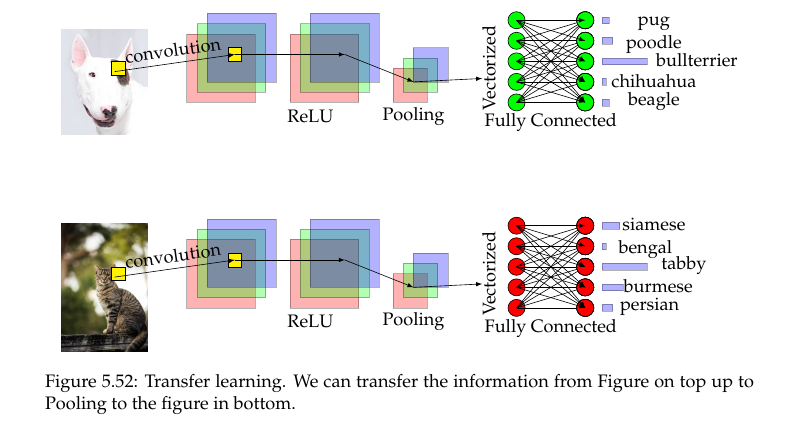

## Historia: Ver las notas de clase.
para la bibliografia. 2010, 2014.

## Conceptos importantes:
* Se comienza con modelos pre-entrenados. Por ejemplo
con ImageNet para "computer vision".

* Fature Extraction: (extraccion de atributos)
Las capas bajas tienen los pesos que queremos importar.
Inicialmente son intactas. Las capas altas (las dos ultimas, por ejemplo se modifican.

* Fine-tunning: En algunos casos se obtiene muchos mas datos sobre un mismo modelo que ya se ha entrenado previamente. Entonces se pueden guardar los pesos y cargarlos en el modelo con datos exendidos.

* Domain Adaptation (adaptacion de dominio). Por ejemplo usted tiene un sistema desarrollado para interpretar imagenes satelitales. Ese mismo sistema se podria adaptar para interpretar imagenes medicas (o sismicas).






## Ventajas y aplicaciones:

### Ventajas
* **Reduce tiempo de computo**: No es lo mismo que comenzar desde 0. Hay menos epocas. La precision de entrada es alta (esto lo veremos en un ejemplo que vamos a mostrar mas abajo).

* **Mejora desempenho (performance) y menos datos. Si hay datos limitados, podemos usar lo que ya tenemos sin necesitad de una cantidad enorme de datos.

* etc.

### Aplicaciones:
* **Computer vision**: reconocimiento facial, deteccion de objetos, labeling (objetos de imagenes)

* NLP: Aplicaciones de "sentimental analysis" (analisis de sentimientos). Clasificacion de texto, traducciones, BERT, GPT.

* **Speech Recognition**: Adaptar de un lenguaje a otro, o adapar acentos.


## Modelos relacionados.
* **Multitask learning**: Se aprende simultaneamente de varios modelos. Esto no lo estudiamos en este curso.
* **fine tunning with new data**: Ya dijimos y usted puede usar nuevos datos sobre mismo modelo para mejorar el sistema. Es posible que inicilamente no se tuvieran suficientes datos pero se hizo un entrenamiento del cual nos queremos beneficiar.

## Donde se consiguen modelos entrenados?

* Modelos construidos en frameworks populares
   * [Tensorflow hub](https://www.tensorflow.org/hub).
   * [Keras pretrained models](https://keras.io/api/applications/)
   * [Pytorch pretrained models](https://pytorch.org/vision/stable/models.html)

* Otros websites con models pre-entrenados.
    * [Hugging Face](https://discuss.huggingface.co/t/free-models-using-api/55532)
    * [Model Zoo](https://modelzoo.co/)
    * [Kaggle models](https://www.kaggle.com/models)
    * y muchos mas.


Vamos a copiar un codigo de
[Assembly AI video](https://www.youtube.com/watch?v=DyPW-994t7w).











In [1]:
# import libraries
import tensorflow as tf
import tensorflow_datasets as tfds



In [2]:
# cargamos los datos del tf_flowers
dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/incomplete.R3XL2T_3.0.1/',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [4]:
# we extract size, names, and classes
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
class_names = info.features['label'].names

# print them
print(f'Number of examples: {num_examples}')
print(f'Number of classes: {num_classes}')
print(f'Class names: {class_names}')

Number of examples: 3670
Number of classes: 5
Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [5]:
test_set_raw, valid_set_raw, train_set_raw = \
    tfds.load('tf_flowers', split=['train[:10%]', 'train[10%:25%]', 'train[25%:]'], as_supervised=True)

In [6]:
# preprocessing
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224,224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image,label

In [7]:
batch_size = 32
train_set = train_set_raw.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)



In [8]:
base_model = tf.keras.applications.xception.Xception(weights='imagenet', include_top=False)

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(avg)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
# no se entrena la base
for layer in base_model.layers:
    layer.trainable = False





In [10]:
optimazer = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimazer, metrics=['accuracy'])

history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 223ms/step - accuracy: 0.7039 - loss: 1.4406 - val_accuracy: 0.8004 - val_loss: 1.6025
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.8863 - loss: 0.8132 - val_accuracy: 0.8566 - val_loss: 1.1440
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.8973 - loss: 0.5850 - val_accuracy: 0.8439 - val_loss: 1.3215
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.9456 - loss: 0.3276 - val_accuracy: 0.8548 - val_loss: 1.2743
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9284 - loss: 0.4127 - val_accuracy: 0.8584 - val_loss: 1.1830


In [11]:
# reentrenar las capas base.
for layer in base_model.layers:
    layer.trainable = True


In [12]:
optimazer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimazer, metrics=['accuracy'])

history = model.fit(train_set, epochs=10, validation_data=valid_set)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


86/86 ━━━━━━━━━━━━━━━━━━━━ 76s 454ms/step - accuracy: 0.7993 - loss: 0.7332 - val_accuracy: 0.8421 - val_loss: 0.6222
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 55s 420ms/step - accuracy: 0.9643 - loss: 0.1235 - val_accuracy: 0.8911 - val_loss: 0.3946
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 421ms/step - accuracy: 0.9855 - loss: 0.0417 - val_accuracy: 0.8838 - val_loss: 0.4537
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 43s 439ms/step - accuracy: 0.9864 - loss: 0.0485 - val_accuracy: 0.9002 - val_loss: 0.3840
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 444ms/step - accuracy: 0.9954 - loss: 0.0148 - val_accuracy: 0.9020 - val_loss: 0.3757
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 445ms/step - accuracy: 0.9943 - loss: 0.0134 - val_accuracy: 0.9056 - val_loss: 0.3910
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 445ms/step - accuracy: 0.9967 - loss: 0.0096 - val_accuracy: 0.9020 - val_loss: 0.4813
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 446ms/step - accuracy: 0.9974 - loss: 0.0124 - val_accuracy: 0.889

# NLP: Natural Language Processing.
NLP es la interseccion ciencia de la computacion, inteligencia artificial y linguistica.

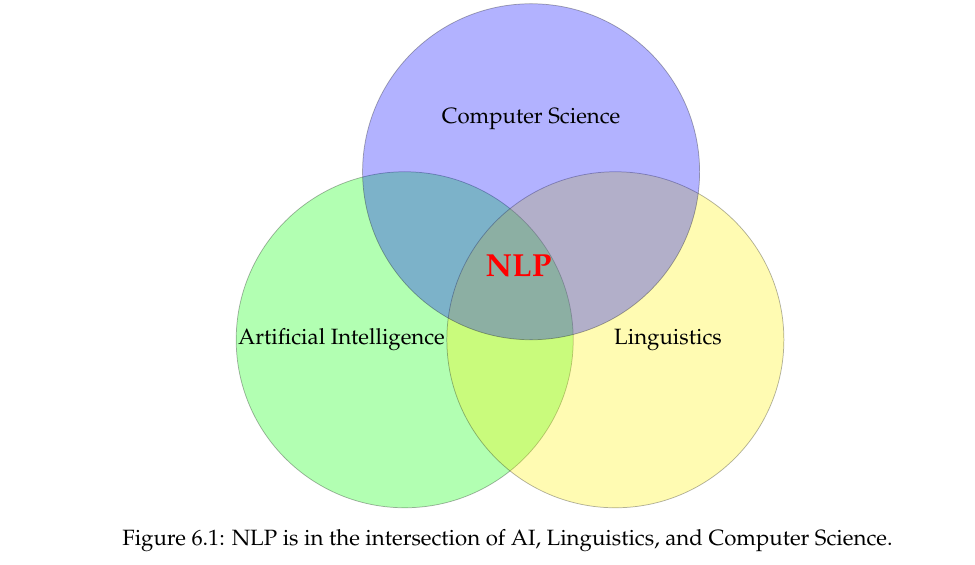

NLP es (de forma simplificada):

* Ciencia de la computacion
* Inteligencia Artificial (AI)
* Linguistica.



Los pasos de NLP son:o

* Speech (habla)
    * Phonetic/Phonolical Analysis
    * Morphological Analysis
    * Syntatic Analysis
    * Semantic Analysis
    * Discourse Processing*
* Text (texto)
    * OCR tokenization
    * Morphological Analysis
    * Syntatic Analysis
    * Semantic Analysis
    * Discourse Processing

OCR: Optical Character Recognition.




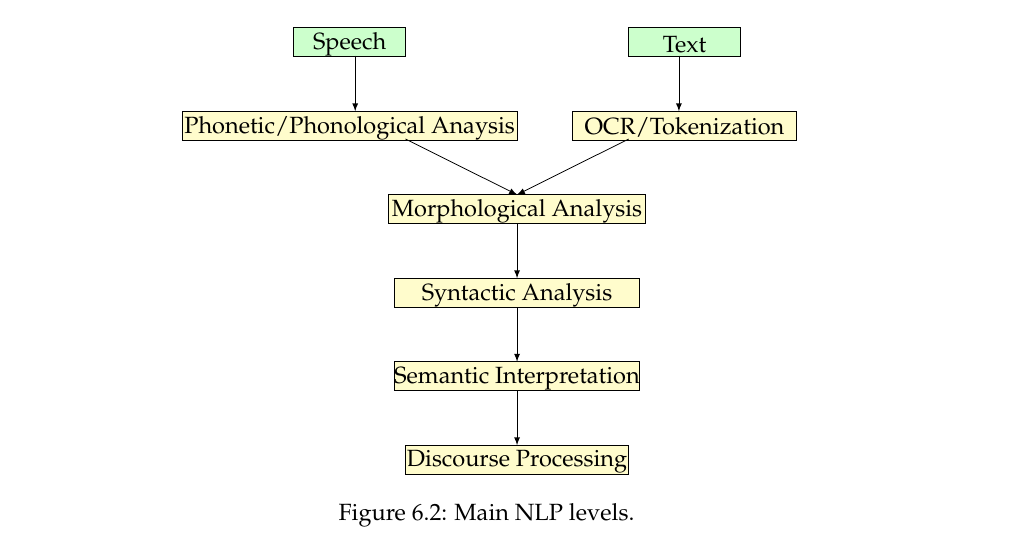

## Word Embeddings (palabras embebidas)
Sabemos muy bien que el compuador no entiende palabras. Solo numeros. Lo que se hace es "embeber" estas palabras en un espacio vectorial real multidimensional $\mathbb{R}^n$. Aplicaciones como

* Siri
* Google Assistant
* Alexa
* Google Translate
* Sentimental analysis
utilizano **word embedding**.
Por ejemplo las aplicaciones que en el telefono adivinan la proxima palabra (WhatsApp) las usan miles de millones de personas diario.

Necesitamos **cuantificar** aspectos como la **semantica** y la **sintaxis**.

En la historia de esto quiero mencionar a Tomas Mikolov, y amigos  en 2013 publicaron "Linguistic Regularities on Continuous Space Word Representations" (referencia en las notas de clase). Ellos usan analogias.
Por ejemplo $a$ es a $b$ como $c$ es a $__$.
Refiriendose a, por ejemplo

"he" is to "she" as "him" is to "__"
El sistema debe adivinar la palabra "her".

Aunque nosotros cuanticemos estas palabras, frases, etc (tokens) no vamos a evitar la **ambiguedad**.

Por ejemplo:
**clothing** is to **shirt** as "dish" is to **bowl**
Donde esta la ambiguedad? esta aca

**clothing** is to **shirt** as **dish** is to **__**
**clothing** is to **shirt** as **dish** is to **cup**
Como se resuelven estas ambiguiedades con "word embedding"?


Mikolov y amigos presentan la figura que muestro a continuacion.


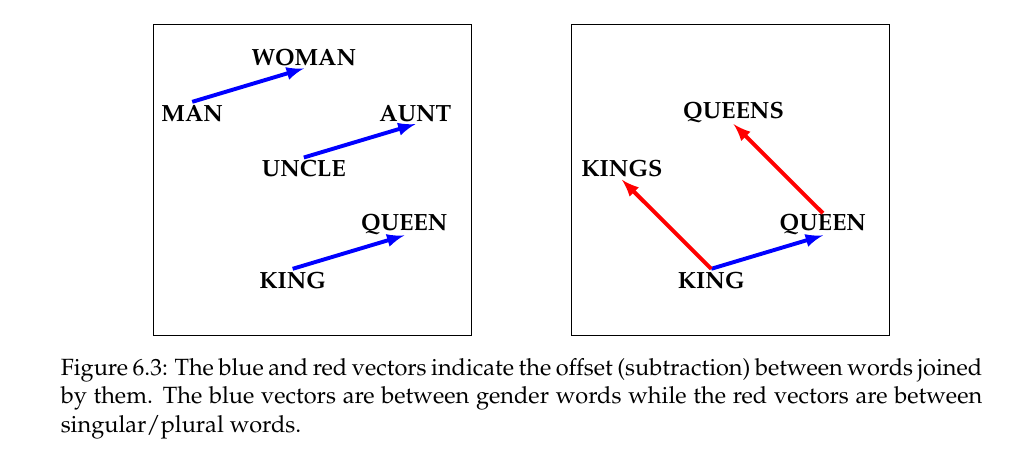

Volvamos a las analogias.
Tenemos matematicamente

$$a:b :: c : __ $$

Si representamos todos estos eventos como vectores $w_b,w_a, w_c, w_d \in \mathbb{R}^n$ tenemos

$$w_b - w_a = w_d - w_c $$
Entonces

$$ w_d = w_b - w_a + w_c $$

El ejemplo clasico de Milov et. al., es

KING-MAN+WOMEN = QUEEN

Se va a acabar la clase pero para donde vamos?

Como vamos a hacer el word embedding?

# Proxima clase.
* One hot encoded. Este no es bueno, lo vamos ver en la proxima clase.

* Metricas (distancias entre palabras). El coseno mejor que la metrica Euclidiana

